# Entrenamiento de RNNs en una Serie de Tiempo

asdasd

In [2]:
import os, time
os.environ['THEANO_FLAGS'] = "device=gpu,floatX=float32,cuda.root=/usr/local/cuda-7.5/,nvcc.flags=-D_FORCE_INLINES" 

import theano
import keras
#print theano.config

from keras.models import Sequential,Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import LSTM, GRU, SimpleRNN
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.utils import np_utils,plot_model
from IPython.display import Image, display, SVG

import scipy.io as sio
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
%env OMP_NUM_THREADS=8
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.})

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce 940M (CNMeM is disabled, cuDNN 5110)
Using Theano backend.


env: OMP_NUM_THREADS=8


Para el desarrollo de esta actividad se utilizará una GPU, utilizando un driver nvidia GeForce 940M, acelerando en una gran nivel los cálculos realizados por la red convolucional.

## a) Cargar los datos

In [3]:
name_f = "international-airline-passengers.csv"
dataframe = pd.read_csv(name_f,sep=',',usecols=[1],engine='python',skipfooter = 3)
dataframe[:] = dataframe[:].astype('float32')
df_train, df_test = dataframe[:96].values, dataframe[96:].values

print dataframe.describe()
print dataframe.shape
total = float(dataframe.shape[0])
n_train = df_train.shape[0]
n_test = df_test.shape[0]
print "Son %d datos de entrenamiento, correspondiente al %f por ciento de los datos"%(n_train,100*n_train/total)
print "Son %d datos de pruebas, correspondiente al %f por ciento de los datos"%(n_test,100*n_test/total)

       International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
count                                         144.000000                             
mean                                          280.298615                             
std                                           119.966316                             
min                                           104.000000                             
25%                                           180.000000                             
50%                                           265.500000                             
75%                                           360.500000                             
max                                           622.000000                             
(144, 1)
Son 96 datos de entrenamiento, correspondiente al 66.666667 por ciento de los datos
Son 48 datos de pruebas, correspondiente al 33.333333 por ciento de los datos


### Escalar los datos

In [4]:
scaler = MinMaxScaler(feature_range=(0,1)).fit(df_train)
stream_train_scaled = scaler.transform(df_train)
stream_test_scaled = scaler.transform(df_test)
print "Valor minimo: ", np.min(stream_train_scaled)
print "Valor maximo: ",np.max(stream_train_scaled)

Valor minimo:  0.0
Valor maximo:  1.0


### Visualización de los datos

In [8]:
fechas = pd.read_csv(name_f,sep=',',usecols=[0],engine='python',skipfooter = 3)
print fechas.head()

meses = ["Enero","Febrero","Marzo","Abril","Mayo","Junio","Julio","Agosto","Septiembre","Octubre","Noviembre","Diciembre"]
secuencia_meses = [ meses[ int(i[0][-2:])-1 ] for i in fechas.values ]

     Month
0  1949-01
1  1949-02
2  1949-03
3  1949-04
4  1949-05


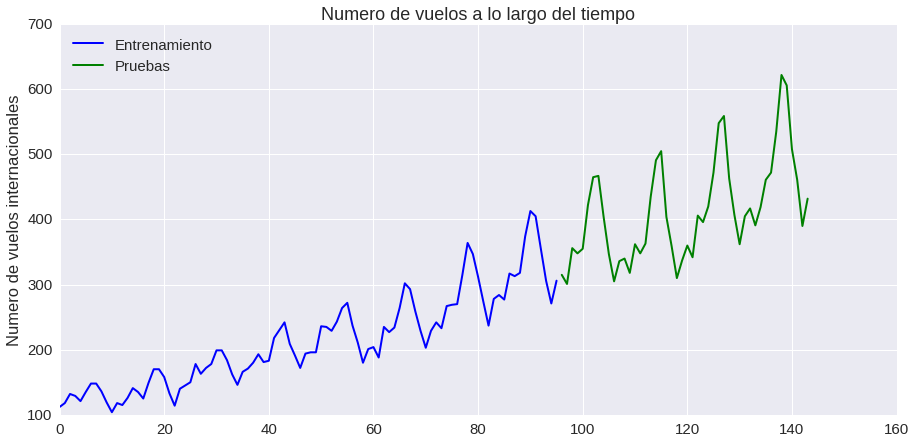

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15,7))

axes.plot(range(n_train),df_train, 'b', label="Entrenamiento")
axes.plot(range(n_train,n_train+n_test),df_test, 'g', label= "Pruebas")
axes.set_title("Numero de vuelos a lo largo del tiempo")
axes.set_ylabel("Numero de vuelos internacionales")
axes.set_xlabel("")
#axes.set_xticks( range(n_train+n_test) )
#axes.set_xticklabels( secuencia_meses, rotation=60 )
axes.legend(loc='upper left')

plt.show()

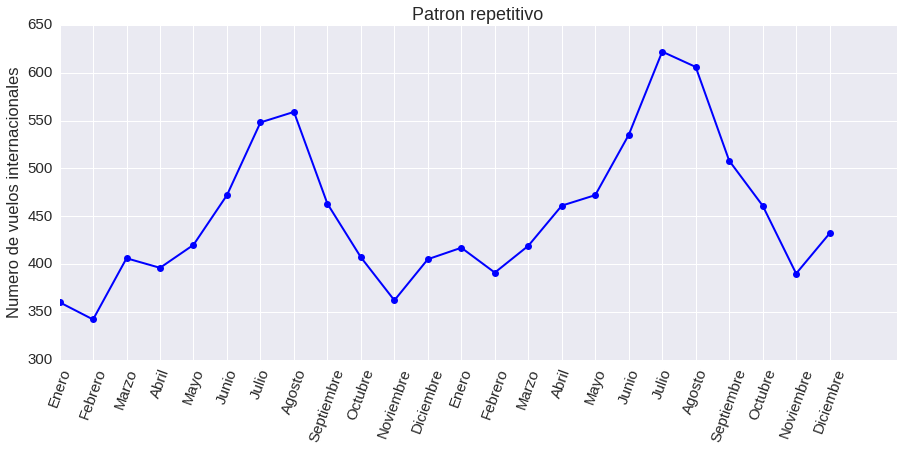

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15,6))

n = 24 #periodo
axes.plot(range(n),dataframe.values[-n:], 'bo-')
axes.set_title("Patron repetitivo")
axes.set_ylabel("Numero de vuelos internacionales")
axes.set_xticks( range(n) )
axes.set_xticklabels( secuencia_meses, rotation=70 )
#axes.set_ylim(300)

plt.show()

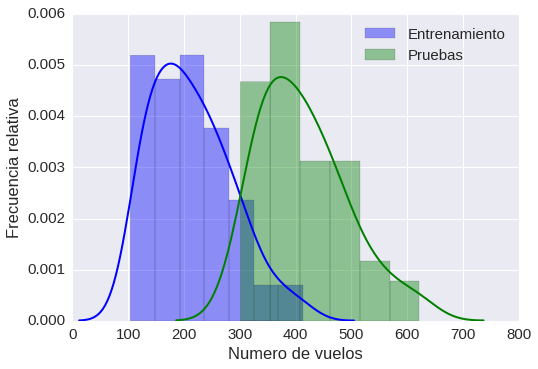

In [20]:
sns.distplot(df_train,color='b', label = "Entrenamiento")#, hist_kws={'alpha': 0.9})
sns.distplot(df_test, color='g', label = "Pruebas")#, hist_kws={'alpha': 0.9})
plt.ylabel("Frecuencia relativa")
plt.xlabel("Numero de vuelos")
plt.legend()
plt.show()

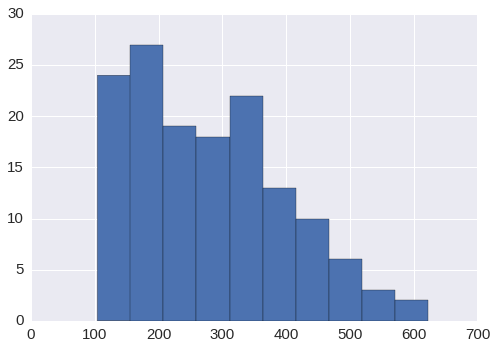

In [30]:
plt.hist(dataframe.values)
#sns.distplot(dataframe.values, color='g', hist_kws={'alpha': 0.9}, kde=False)
plt.xlim(0)
plt.show()

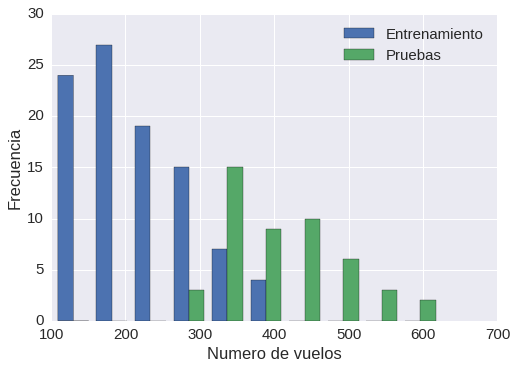

In [46]:
plt.hist([df_train,df_test], label=["Entrenamiento","Pruebas"])
plt.xlabel("Numero de vuelos")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

## b) Preprocesar datos (secuencia)

In [5]:
def create_dataset(secuencia,lag =1): 
    #preprocesamiento asumiendo dataset es una secuencia
    dataX = []
    dataY =[]
    for t_plus_1 in range(lag,len(secuencia)):
        #se crea el Y (target)
        predecir = secuencia[t_plus_1]
        dataY+= list(predecir) 
        
        #se crea el X (inputs) columnas para predecir Y
        columnasX = []
        for i in np.arange(lag,0,-1): #para los valores anteriores al t_plus_1 durante un lag
            columnasX += list( secuencia[t_plus_1-i] )
        dataX.append(columnasX)
    return np.array(dataX),np.array(dataY)
#create_dataset(stream_train_scaled)

In [6]:
lag = 3
trainX, trainY = create_dataset(df_train, lag)

length = 12
sec = df_train[:length]
print "Secuencia hasta los ",length
print sec.T[0]

#para visualizar que se hizo bien
datos = []
for m in range(length-lag):
    x= trainX[m]
    y= trainY[m]

    aux = ["-"] + [ "X"+str(i) for i in range(lag)] +["Y"]
    datos += [ ["Dato " + str(m)]+ list(x) + [y] ] 
from tabulate import tabulate
print tabulate(datos, headers = aux, tablefmt = "fancy_grid")

Secuencia hasta los  12
[ 112.  118.  132.  129.  121.  135.  148.  148.  136.  119.  104.  118.]
╒════════╤══════╤══════╤══════╤═════╕
│ -      │   X0 │   X1 │   X2 │   Y │
╞════════╪══════╪══════╪══════╪═════╡
│ Dato 0 │  112 │  118 │  132 │ 129 │
├────────┼──────┼──────┼──────┼─────┤
│ Dato 1 │  118 │  132 │  129 │ 121 │
├────────┼──────┼──────┼──────┼─────┤
│ Dato 2 │  132 │  129 │  121 │ 135 │
├────────┼──────┼──────┼──────┼─────┤
│ Dato 3 │  129 │  121 │  135 │ 148 │
├────────┼──────┼──────┼──────┼─────┤
│ Dato 4 │  121 │  135 │  148 │ 148 │
├────────┼──────┼──────┼──────┼─────┤
│ Dato 5 │  135 │  148 │  148 │ 136 │
├────────┼──────┼──────┼──────┼─────┤
│ Dato 6 │  148 │  148 │  136 │ 119 │
├────────┼──────┼──────┼──────┼─────┤
│ Dato 7 │  148 │  136 │  119 │ 104 │
├────────┼──────┼──────┼──────┼─────┤
│ Dato 8 │  136 │  119 │  104 │ 118 │
╘════════╧══════╧══════╧══════╧═════╛


## c) Generar secuencias de entrenamiento y pruebas

In [7]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)

## d) Reshape

In [8]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## e) Entrenar LSTM

In [14]:
model = Sequential()
model.add(LSTM(4, input_shape= (None,lag) , activation='tanh', recurrent_activation='sigmoid'))
model.add(Dense(1, activation = 'linear'))
print model.summary()

start_time = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
hist = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
print('Tiempo en entrenar: %f'%(time.time() - start_time ))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 128       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________
None
Tiempo en entrenar: 44.509043


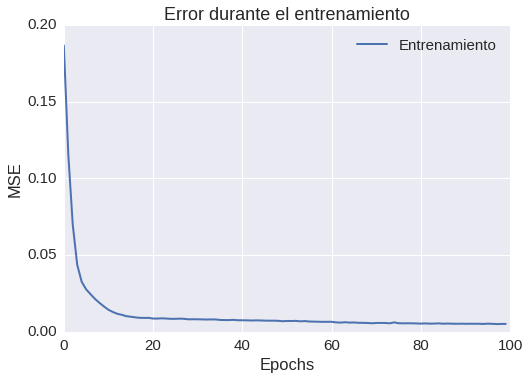

In [15]:
plt.plot(range(100),hist.history['loss'],label="Entrenamiento")
plt.title("Error durante el entrenamiento")
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## f) Predecir con el modelo

In [16]:
#entrenamiento
trainPredict = model.predict(trainX)

#invertir escalamiento
trainPredict = scaler.inverse_transform(trainPredict)
trainY_recuperado = scaler.inverse_transform([trainY])

#pruebas
testPredict = model.predict(testX)

#invertir escalamiento
testPredict = scaler.inverse_transform(testPredict)
testY_recuperado = scaler.inverse_transform([testY])

## g) Computar error

In [17]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY_recuperado[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY_recuperado[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21.81 RMSE
Test Score: 64.88 RMSE


## h) Graficar prediccion vs real

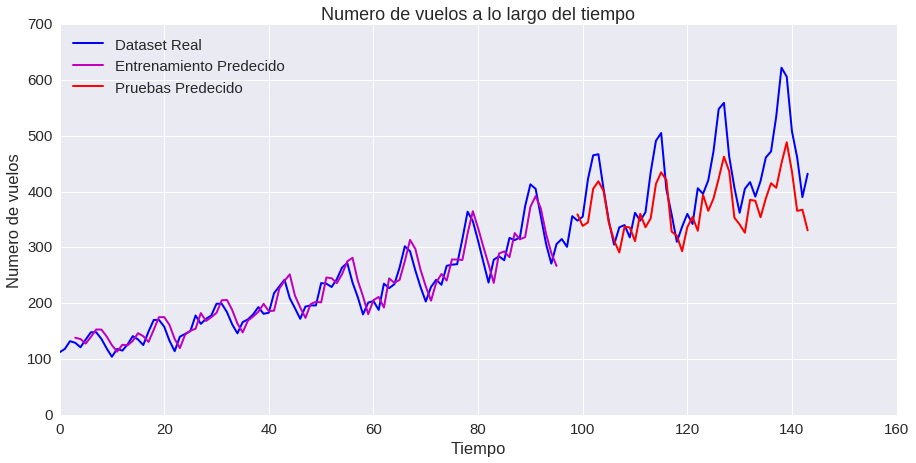

In [18]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan

trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan

testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict

plt.figure(figsize=(15,7))
plt.plot(dataframe.values,'b', label = "Dataset Real")
plt.plot(trainPredictPlot,'m', label= "Entrenamiento Predecido")
plt.plot(testPredictPlot,'r', label= "Pruebas Predecido")
plt.ylim(0)
plt.ylabel("Numero de vuelos")
plt.xlabel("Tiempo")
plt.title("Numero de vuelos a lo largo del tiempo")
plt.legend(loc="upper left")
plt.show()

## h) Variar numero de bloques

In [24]:
def computar_error(modelo,X,Y):
    Ypredict = modelo.predict(X)
    #invertir escalamiento
    Ypredict = scaler.inverse_transform(Ypredict)
    Yreal = scaler.inverse_transform([Y])

    return np.sqrt(mean_squared_error(Yreal[0], Ypredict[:,0]))

In [59]:
def create_model(bloques,lag):
    # create your model using this function
    model = Sequential()
    model.add(LSTM(units=bloques, input_shape=(None,lag), activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dense(1, activation = 'linear'))

    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

nb=range(4,13,2)

for bloques in nb:                                                                    
    kf = KFold(n_splits=5)
    error_cv = []
    tiempo_entrenarse = []
    for cv_train, cv_val in kf.split(trainX):#por cada fold
        model = create_model(bloques,lag=3)
       
        start_time = time.time()
        #entrenar    
        model.fit(trainX[cv_train], trainY[cv_train], epochs=100, batch_size=1, verbose=0)
        
        tiempo_entrenarse.append(time.time() - start_time )

        #computar error
        valScore = computar_error(model,trainX[cv_val],trainY[cv_val]) 
        error_cv.append(valScore)
    print('VAL Score con %d bloques: %.2f RMSE ---demorandose: %f seg' % 
          (bloques,np.mean(error_cv),np.mean(tiempo_entrenarse)))

VAL Score con 4 bloques: 23.11 RMSE ---demorandose: 33.082479 seg
VAL Score con 6 bloques: 23.00 RMSE ---demorandose: 35.006944 seg
VAL Score con 8 bloques: 22.86 RMSE ---demorandose: 34.947999 seg
VAL Score con 10 bloques: 24.29 RMSE ---demorandose: 31.336449 seg
VAL Score con 12 bloques: 22.18 RMSE ---demorandose: 35.209840 seg


"\ndef C_V(Xm,ym, K=10):\n    k_fold = cross_validation.KFold(len(Xm),K)\n    mse_cv = 0\n    for k, (train, val) in enumerate(k_fold):\n        linreg = lm.LinearRegression(fit_intercept = False)\n        linreg.fit(Xm[train], ym[train])\n        yhat_val = linreg.predict(Xm[val])\n        mse_fold = np.mean(np.power(yhat_val - ym[val], 2))\n        mse_cv += mse_fold\n    mse_cv = mse_cv / K\n    return mse_cv\n    #entrenamiento\nvalPredict = model.predict(valX)\n\n#invertir escalamiento\nvalPredict = scaler.inverse_transform(valPredict)\nvalY = scaler.inverse_transform([valY])\n\nvalScore = np.sqrt(mean_squared_error(valY[0], valPredict[:,0]))\nprint('val Score con %d bloques: %.2f RMSE' % (bloques,valScore))\n"

### Se escoge el mejor modelo: 12 bloques

In [26]:
#mejor modelo
model = Sequential()
model.add(LSTM(units=12, input_shape=(None,lag), activation='tanh', recurrent_activation='sigmoid'))
model.add(Dense(1, activation = 'linear'))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

#computar error
trainScore = computar_error(model,trainX,trainY)
testScore = computar_error(model,testX,testY)
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score con 12 bloques: %.2f RMSE' %(testScore) )

Train Score: 21.27 RMSE
Test Score con 12 bloques: 57.41 RMSE


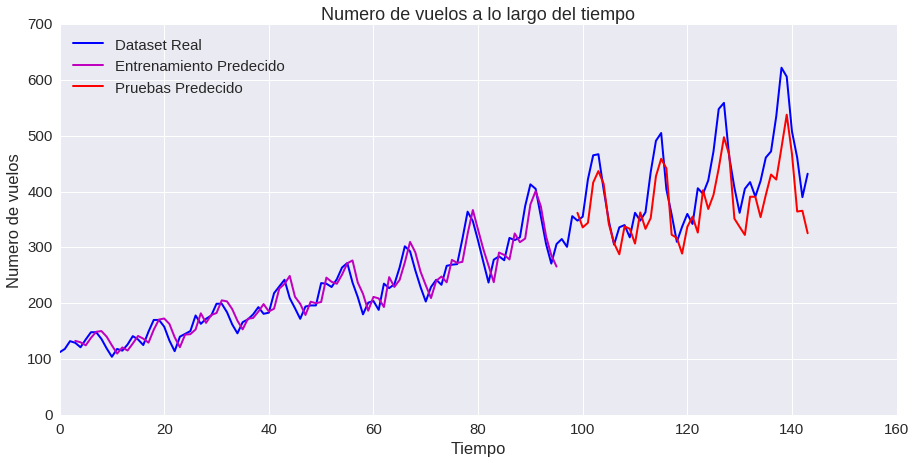

In [27]:
#entrenamiento
trainPredict = model.predict(trainX)
#invertir escalamiento
trainPredict = scaler.inverse_transform(trainPredict)

#pruebas
testPredict = model.predict(testX)
#invertir escalamiento
testPredict = scaler.inverse_transform(testPredict)


# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan

trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan

testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict

plt.figure(figsize=(15,7))
plt.plot(dataframe.values,'b', label = "Dataset Real")
plt.plot(trainPredictPlot,'m', label= "Entrenamiento Predecido")
plt.plot(testPredictPlot,'r', label= "Pruebas Predecido")

plt.ylim(0)
plt.ylabel("Numero de vuelos")
plt.xlabel("Tiempo")
plt.title("Numero de vuelos a lo largo del tiempo")
plt.legend(loc="upper left")
plt.show()

## i) Variar el lag

In [28]:
def generar_secuencias(datos_entrenamiento, datos_pruebas,lag=1):
    trainX, trainY = create_dataset(datos_entrenamiento, lag)
    testX, testY = create_dataset(datos_pruebas, lag)
    #reshape
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    return trainX,trainY, testX, testY

In [12]:
lags = [1,2,3,4]

for lag in lags:
    trainX,trainY, testX,testY = generar_secuencias(stream_train_scaled,stream_test_scaled,lag = lag)

    kf = KFold(n_splits=5)
    error_cv = []
    tiempo_entrenarse = []
    for cv_train, cv_val in kf.split(trainX):#por cada fold
        #crear modelo
        model = Sequential()
        model.add(LSTM(4, input_shape= (None,lag) , activation='tanh', recurrent_activation='sigmoid'))
        model.add(Dense(1, activation = 'linear'))
        
        start_time = time.time()
        #entrenar    
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(trainX[cv_train], trainY[cv_train], epochs=100, batch_size=1, verbose=0)
        
        tiempo_entrenarse.append(time.time() - start_time )
        
        #computar error
        valScore = computar_error(model,trainX[cv_val],trainY[cv_val]) 
        error_cv.append(valScore)
    print('VAL Score con lag %d : %.2f RMSE ---demorandose: %f seg' % 
          (lag,np.mean(error_cv),np.mean(tiempo_entrenarse)))

VAL Score con lag 1 : 22.80 RMSE ---demorandose: 33.381157 seg
VAL Score con lag 2 : 24.13 RMSE ---demorandose: 31.758656 seg
VAL Score con lag 3 : 22.97 RMSE ---demorandose: 34.764618 seg
VAL Score con lag 4 : 23.63 RMSE ---demorandose: 36.400571 seg


### Se escoge la mejor: lag igual a 1

In [29]:
#elegir la mejor y ver...
lag = 1
trainX,trainY, testX,testY = generar_secuencias(stream_train_scaled,stream_test_scaled,lag = lag)
model = Sequential()
model.add(LSTM(4, input_shape= (None,lag) , activation='tanh', recurrent_activation='sigmoid'))
model.add(Dense(1, activation = 'linear'))

#entrenar    
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

#computar error
trainScore = computar_error(model,trainX,trainY)
testScore = computar_error(model,testX,testY)
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score con 12 bloques: %.2f RMSE' %(testScore) )

Train Score: 22.80 RMSE
Test Score con 12 bloques: 53.73 RMSE


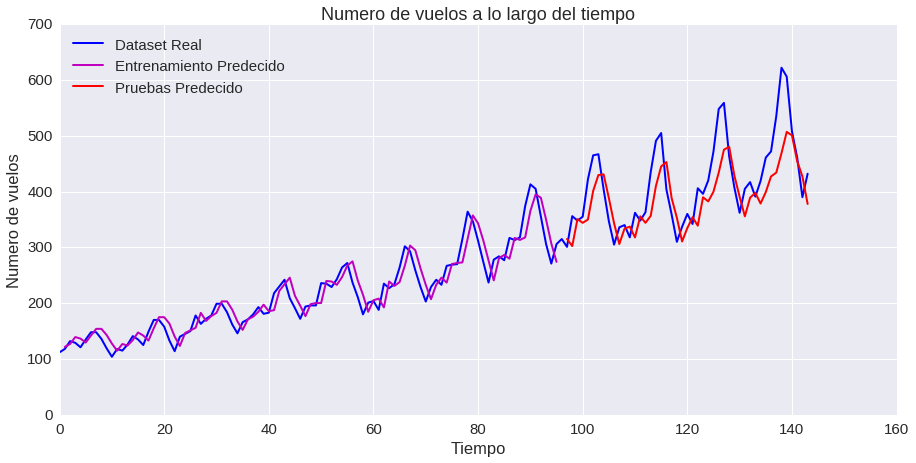

In [30]:
#entrenamiento
trainPredict = model.predict(trainX)
#invertir escalamiento
trainPredict = scaler.inverse_transform(trainPredict)

#pruebas
testPredict = model.predict(testX)
#invertir escalamiento
testPredict = scaler.inverse_transform(testPredict)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict

plt.figure(figsize=(15,7))
plt.plot(dataframe.values,'b', label = "Dataset Real")
plt.plot(trainPredictPlot,'m', label= "Entrenamiento Predecido")
plt.plot(testPredictPlot,'r', label= "Pruebas Predecido")
plt.ylim(0)
plt.ylabel("Numero de vuelos")
plt.xlabel("Tiempo")
plt.title("Numero de vuelos a lo largo del tiempo")
plt.legend(loc="upper left")
plt.show()

## j) Comparar desempeño

In [31]:
def modelo_gru(inp):
    model = Sequential()
    model.add(GRU(units=4, input_shape=(None,inp), recurrent_initializer='orthogonal', activation='tanh'))
    model.add(Dense(1, activation = 'linear'))
    return model
def modelo_simple(inp):
    model = Sequential()
    model.add(SimpleRNN(units=4, input_shape=(None,inp), recurrent_initializer='orthogonal',activation='tanh'))
    model.add(Dense(1, activation = 'linear'))
    return model  

trainX,trainY, testX,testY = generar_secuencias(stream_train_scaled,stream_test_scaled,lag = 3)
    
#modelo gru
model = modelo_gru(trainX.shape[2])

start_time = time.time()
#entrenar    
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

print('MODELO GRU')
print('Tiempo en entrenar: %f'%(time.time() - start_time ))
print('Train Score: %.2f RMSE' % (computar_error(model,trainX,trainY)))
print('Test Score: %.2f RMSE' % (computar_error(model,testX,testY)))

#modelo simpleRNN
model = modelo_simple(trainX.shape[2])

start_time = time.time()
#entrenar    
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

print('MODELO SIMPLERNN')
print('Tiempo en entrenar: %f'%(time.time() - start_time ))
print('Train Score: %.2f RMSE' % (computar_error(model,trainX,trainY)))
print('Test Score: %.2f RMSE' % (computar_error(model,testX,testY)))

MODELO GRU
Tiempo en entrenar: 44.283741
Train Score: 22.65 RMSE
Test Score: 63.50 RMSE
MODELO SIMPLERNN
Tiempo en entrenar: 26.879021
Train Score: 21.35 RMSE
Test Score: 48.56 RMSE


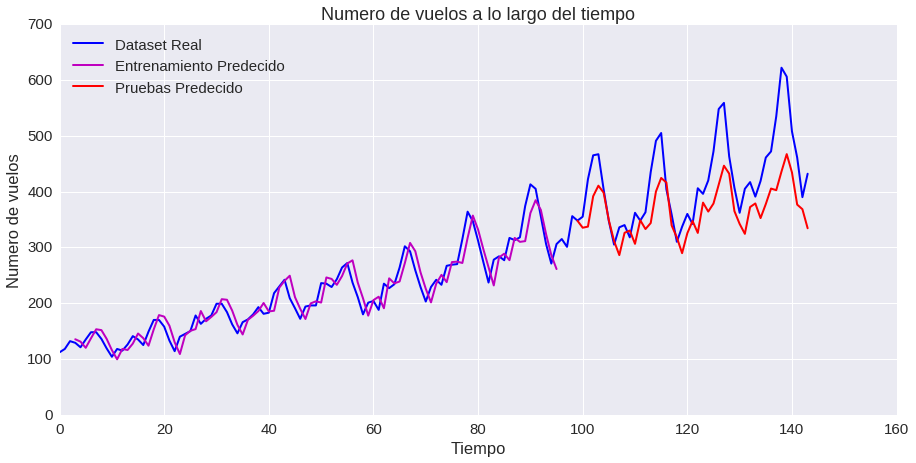

In [34]:
## si alguno es de verdad mejor visualizarlo
model = modelo_simple(trainX.shape[2])

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

#entrenamiento
trainPredict = model.predict(trainX)
trainPredict = scaler.inverse_transform(trainPredict)

#pruebas
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict

plt.figure(figsize=(15,7))
plt.plot(dataframe.values,'b', label = "Dataset Real")
plt.plot(trainPredictPlot,'m', label= "Entrenamiento Predecido")
plt.plot(testPredictPlot,'r', label= "Pruebas Predecido")
plt.ylim(0)
plt.ylabel("Numero de vuelos")
plt.xlabel("Tiempo")
plt.title("Numero de vuelos a lo largo del tiempo")
plt.legend(loc="upper left")
plt.show()

## k) variar Timestep

In [73]:
#crear
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

print "un input: ", scaler.inverse_transform(trainX[0])
print "target: ",scaler.inverse_transform(trainY[0].reshape(-1,1))

model = Sequential()
model.add(LSTM(4, input_shape= (None,1) , activation='tanh', recurrent_activation='sigmoid'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
start_time= time.time()
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

print('Tiempo en entrenar: %f'%(time.time() - start_time ))
print('Train Score: %.2f RMSE' % (computar_error(model,trainX,trainY)))
print('Test Score: %.2f RMSE' % (computar_error(model,testX,testY)))

un input:  [[ 112.]
 [ 118.]
 [ 132.]]
target:  [[ 129.]]
Tiempo en entrenar: 60.213174
Train Score: 21.90 RMSE
Test Score: 52.96 RMSE


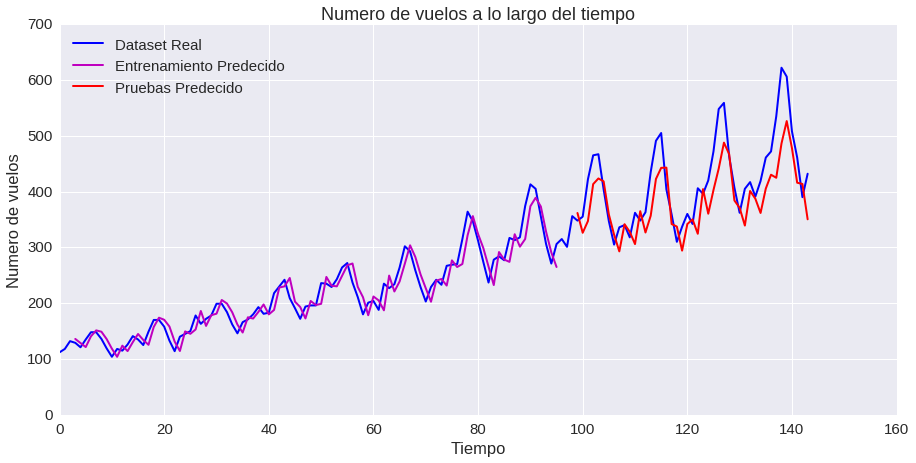

In [74]:
#entrenamiento
trainPredict = model.predict(trainX)
trainPredict = scaler.inverse_transform(trainPredict)

#pruebas
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict

plt.figure(figsize=(15,7))
plt.plot(dataframe.values,'b', label = "Dataset Real")
plt.plot(trainPredictPlot,'m', label= "Entrenamiento Predecido")
plt.plot(testPredictPlot,'r', label= "Pruebas Predecido")
plt.ylim(0)
plt.ylabel("Numero de vuelos")
plt.xlabel("Tiempo")
plt.title("Numero de vuelos a lo largo del tiempo")
plt.legend(loc="upper left")
plt.show()

## k) memoria Batches

In [38]:
def computar_error(modelo,X,Y,batch):
    Ypredict = modelo.predict(X,batch_size=batch)
    #invertir escalamiento
    Ypredict = scaler.inverse_transform(Ypredict)
    Yreal = scaler.inverse_transform([Y])

    return np.sqrt(mean_squared_error(Yreal[0], Ypredict[:,0]))

In [50]:
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True,activation='tanh', recurrent_activation='sigmoid'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

start_time= time.time()
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
print('Tiempo en entrenar: %f'%(time.time() - start_time ))
print('Train Score: %.2f RMSE' % (computar_error(model,trainX,trainY,batch_size)))
print('Test Score: %.2f RMSE' % (computar_error(model,testX,testY,batch_size)))

Tiempo en entrenar: 60.495877
Train Score: 21.58 RMSE
Test Score: 47.84 RMSE


## l) variar tamaño de batch a 3

In [56]:
batch_size = 3
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True, activation='tanh', recurrent_activation='sigmoid'))
model.add(Dense(1, activation ='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
start_time = time.time()
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
print('Tiempo en entrenar: %f'%(time.time() - start_time ))
print('Train Score: %.2f RMSE' % (computar_error(model,trainX,trainY,batch_size)))
print('Test Score: %.2f RMSE' % (computar_error(model,testX,testY,batch_size)))

Tiempo en entrenar: 29.211032
Train Score: 27.78 RMSE
Test Score: 58.04 RMSE


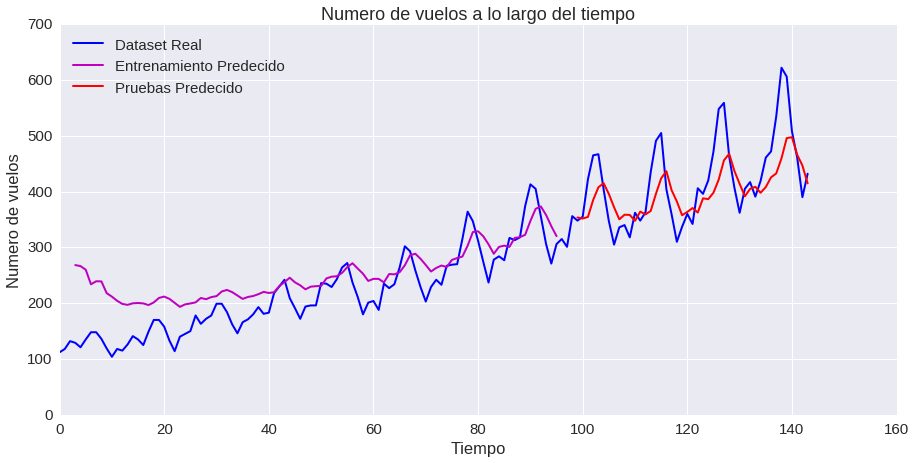

In [57]:
#entrenamiento
trainPredict = model.predict(trainX,batch_size)
trainPredict = scaler.inverse_transform(trainPredict)

#pruebas
testPredict = model.predict(testX,batch_size)
testPredict = scaler.inverse_transform(testPredict)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict

plt.figure(figsize=(15,7))
plt.plot(dataframe.values,'b', label = "Dataset Real")
plt.plot(trainPredictPlot,'m', label= "Entrenamiento Predecido")
plt.plot(testPredictPlot,'r', label= "Pruebas Predecido")
plt.ylim(0)
plt.ylabel("Numero de vuelos")
plt.xlabel("Tiempo")
plt.title("Numero de vuelos a lo largo del tiempo")
plt.legend(loc="upper left")
plt.show()

## m) LSTM apilada

In [65]:
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'))
model.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True, activation='tanh', recurrent_activation='sigmoid'))
model.add(Dense(1, activation ='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
start_time = time.time()
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
print('Tiempo en entrenar: %f'%(time.time() - start_time ))
print('Train Score: %.2f RMSE' % (computar_error(model,trainX,trainY,batch_size)))
print('Test Score: %.2f RMSE' % (computar_error(model,testX,testY,batch_size)))

Tiempo en entrenar: 112.314323
Train Score: 22.52 RMSE
Test Score: 61.54 RMSE


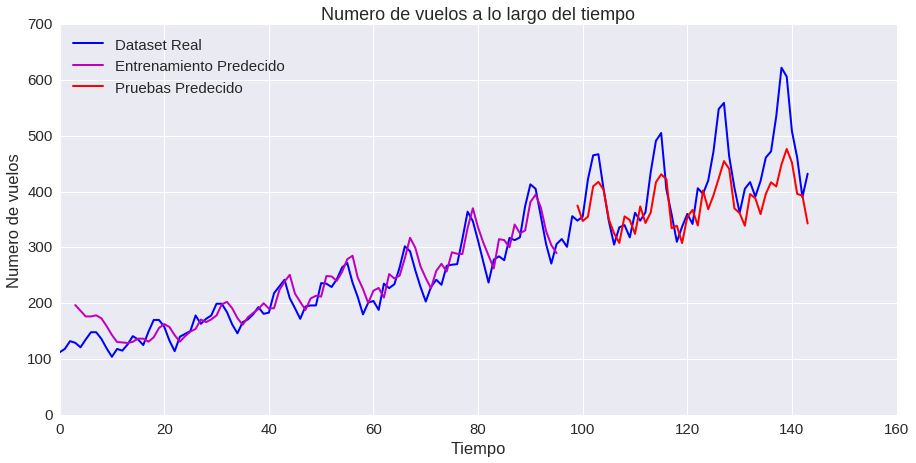

In [66]:
#entrenamiento
trainPredict = model.predict(trainX,batch_size)
trainPredict = scaler.inverse_transform(trainPredict)

#pruebas
testPredict = model.predict(testX,batch_size)
testPredict = scaler.inverse_transform(testPredict)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict

plt.figure(figsize=(15,7))
plt.plot(dataframe.values,'b', label = "Dataset Real")
plt.plot(trainPredictPlot,'m', label= "Entrenamiento Predecido")
plt.plot(testPredictPlot,'r', label= "Pruebas Predecido")
plt.ylim(0)
plt.ylabel("Numero de vuelos")
plt.xlabel("Tiempo")
plt.title("Numero de vuelos a lo largo del tiempo")
plt.legend(loc="upper left")
plt.show()